In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter


In [3]:
# Define base directory relative to the notebook
BASE_DIR = os.getcwd()  # Gets the current working directory

csv_file_path = os.path.join(BASE_DIR, "execution_results.csv")
log_file_path = os.path.join(BASE_DIR, "merged_execution_log.txt")


# Load execution results CSV
df = pd.read_csv(csv_file_path)

In [4]:


# Load the execution results CSV file
execution_results = pd.read_csv(csv_file_path)

# Extract only the file names from the "R/Rmd Script" column
execution_results["R/Rmd Script"] = execution_results["R/Rmd Script"].apply(lambda x: os.path.basename(str(x)))

# Save the cleaned CSV filee
cleaned_csv_path = "execution_results_cleaned.csv"
execution_results.to_csv(cleaned_csv_path, index=False)



In [5]:
# Identify and remove duplicate entries based on "Project ID" and "R/Rmd Script"
execution_results_no_duplicates = execution_results.drop_duplicates(subset=["Project ID", "R/Rmd Script"], keep="first")

execution_results_no_duplicates.to_csv(cleaned_csv_path, index=False)

In [6]:
all_projects = set(df["Project ID"].unique())
print("All Project IDs:", all_projects)

All Project IDs: {'vphyt', '7xsfj', '7vbtr', 'w4gey', '2phst', 'n3zfp', '6q73b', 'dzwct', 'dngyk', '5y27d', 'jh47m', '4a9b6', 'qxf5t', 'wc3nq', 'dr8gy', '4sjxz', 'fbj3z', 'ntw7d', '8abj4', '9e3cu', '2yq8a', 'vwq9p', 'fr5ed', 'wbyj7', 'wgneh', 'rbxzs', 'w7afh', '7z3mk', '8akru', 'qbgct', 'ztycp', 'rf6zu', '4fvwe', 'aczx5', 'yfegm', 'd9jny', 'rh2sw', 'eks6u', 'rmcuy', '3gfqn', 'ynx3m', 'qynhu', '5ejcq', 'fykpt', 'qy5sd', 'd3tg5', 'mbf32', '92e6c', 'qrv2e', 't2jka', '3bn9u', 'skp56', 'xcthg', '6pq9e', 'ujpyn', '4anzm', '3hgpe', 'q2zrp', 'hbju7', '37rfb', 'dgt8x', 'mc26t', 'gk6jh', '2sz48', 'sx6yf', '8edp7', 'pk9my', 'uhma8', '6qej7', 'rtmyx', 'guqrm', '5te7n', 'emwgp', 'dcw4x', '6579b', 'qrvje', 'zhf98', 'vjeb3', '2uf8j', 't7a28', '6g4js', '9gjyc', 'xjm6z', 'gy5vm', 'dqc3y', 'x72cy', 'he8mu', 'r24vb', 'nxyh3', '5yvnb', 'tfbps', '6hx2n', 'p6msu', '7vbj9', 'kbjw9', 'p2xgq', 'jy5wd', '7h94n', '2sguf', 'z6nm8', '49sq5', 'kgtx6', 'k853j', '8fzns', 'f3qrh', 'z39us', '3kem6', '3w8eg', 'fwc2p', '

In [7]:
df["Project ID"].nunique()

253

In [8]:
# Count Success and Failures per Project
success_fail_count = df.groupby("Project ID")["Execution Status"].value_counts().unstack().fillna(0)

# Ensure 'Successful' comes before 'Failed' in the DataFrame
success_fail_count = success_fail_count[['Successful', 'Failed']]


In [9]:
success_fail_count

Execution Status,Successful,Failed
Project ID,,
25a6x,0.0,2.0
2j47e,0.0,6.0
2phst,0.0,2.0
2qjn5,0.0,2.0
2sguf,0.0,1.0
...,...,...
zcv4m,0.0,2.0
zfqax,0.0,2.0
zhf98,0.0,1.0


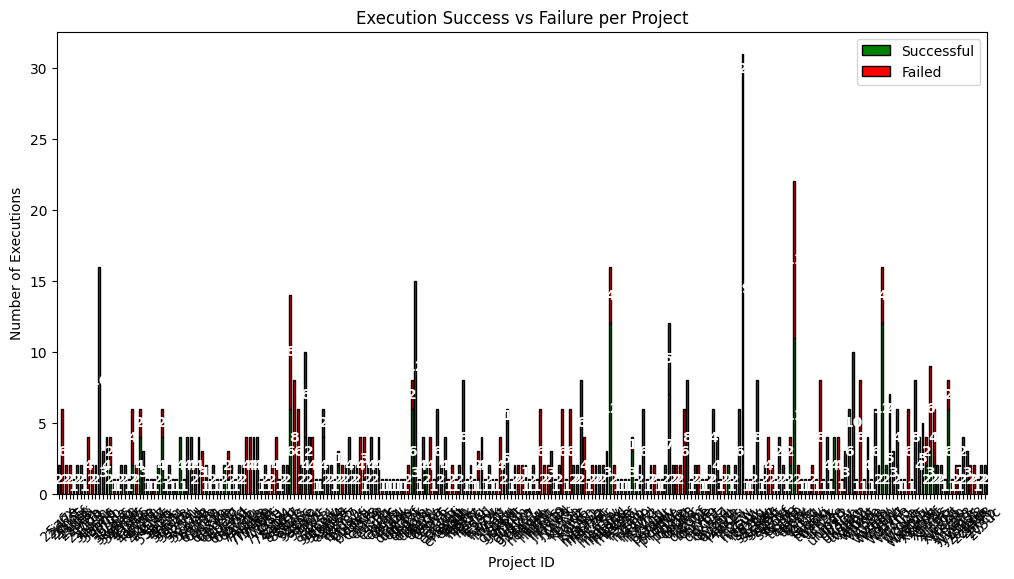

In [10]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
success_fail_count.plot(kind="bar", stacked=True, color=["green", "red"], edgecolor="black", ax=ax)

# Add labels
for idx, (success, fail) in enumerate(zip(success_fail_count["Successful"], success_fail_count["Failed"])):
    x = idx  # Bar index
    if success > 0:
        ax.text(x, success / 2, str(int(success)), ha="center", va="center", fontsize=10, color="white", fontweight="bold")  # Centered on green
    if fail > 0:
        ax.text(x, success + (fail / 2), str(int(fail)), ha="center", va="center", fontsize=10, color="white", fontweight="bold")  # Centered on red

# Titles & Labels
ax.set_title("Execution Success vs Failure per Project")
ax.set_xlabel("Project ID")
ax.set_ylabel("Number of Executions")
ax.legend(["Successful", "Failed"])
plt.xticks(rotation=45)

plt.show()

In [58]:
# Read the merged execution log file
with open(log_file_path, "r", encoding="utf-8") as file:
    log_data = file.readlines()

# Extract error messages using regex
error_patterns = [
    #r"Error occurred: (.+)", 
    #r"Error in .*?: (.+)",  # Matches common R error messages
    #r"Execution halted",    # General failure indicator
    #r"unable to load shared object '.*?': (.+)",  # Shared object errors
    #r"there is no package called ‘(.+?)’"  # Missing package errors
    r"cannot change working directory"
    #r"cannot open file '(.*?)'"
]

# Store extracted errors
error_messages = []

for line in log_data:
    for pattern in error_patterns:
        match = re.search(pattern, line)
        if match and match.groups():  # ✅ Ensure there is a valid group
            error_messages.append(match.group(1))  # ✅ Only append if group(1) exists


In [59]:
# Count error occurrences
error_counts = Counter(error_messages)

# Convert to DataFrame
error_df = pd.DataFrame(error_counts.items(), columns=["Error Message", "Count"]).sort_values(by="Count", ascending=False)


In [60]:
from IPython.display import display

# Display the DataFrame in Jupyter Notebook
display(error_df)


,Error Message,Count


In [57]:
total_errors = error_df["Count"].sum()
print(f"🔍 Total number of errors: {total_errors}")

🔍 Total number of errors: 65


In [93]:


# Define relative paths
log_file_path = os.path.join(BASE_DIR, "merged_execution_log.txt")
output_csv_path = os.path.join(BASE_DIR, "project_error_counts.csv")

# Ensure the log file exists
if not os.path.exists(log_file_path):
    print(f"❌ Error: Log file '{log_file_path}' not found.")
    exit()

# Read log file
with open(log_file_path, "r", encoding="utf-8") as file:
    log_data = file.readlines()

# Lists to store extracted project IDs, R scripts, and errors
project_errors = []

# Regex patterns
project_pattern = re.compile(r"=== Project (\w+) Execution Log ===")  # Extract Project ID
script_pattern = re.compile(r"File: (.+\.(?:Rmd?|rmd?|R|r))")  # Extract R Script filename
error_pattern = re.compile(r"Execution Failed:\n([\s\S]+?)Execution halted")  # Extract Errors

current_project = None
current_script = None

# Extract Project IDs, R Scripts, and Errors
for i, line in enumerate(log_data):
    project_match = project_pattern.search(line)
    if project_match:
        current_project = project_match.group(1)  # Capture Project ID
        current_script = None  # Reset script when a new project starts

    script_match = script_pattern.search(line)
    if script_match and current_project:
        current_script = os.path.basename(script_match.group(1))  # Extract only script filename
    
    error_match = error_pattern.search("".join(log_data[i:i+10]))  # Look at next 10 lines for error
    if error_match and current_project and current_script:
        error_message = error_match.group(1).strip().split("\n")[0]  # Capture first line of error
        project_errors.append((current_project, current_script, error_message))

# Convert extracted errors to DataFrame
df_errors = pd.DataFrame(project_errors, columns=["Project ID", "R Script", "Error Message"])

# Count occurrences of each error per project
df_error_counts = df_errors.groupby(["Project ID", "R Script", "Error Message"]).size().reset_index(name="Count")

# Save to CSV
df_error_counts.to_csv(output_csv_path, index=False)

# Display confirmation message
if not df_error_counts.empty:
    print(f"✅ Project-wise error counts with associated R scripts saved to '{output_csv_path}'")
else:
    print("⚠️ No errors found in the log file!")

# Display first few rows
print(df_error_counts.head())


✅ Project-wise error counts with associated R scripts saved to '/Users/fury/project_error_counts.csv'
  Project ID                                  R Script  \
0      25a6x                BeliefsScale_IRT_Rscript.R   
1      2j47e  Cluster analysis refined factor scores.R   
2      2j47e                            Demographics.R   
3      2j47e                         Factor analysis.R   
4      2j47e                                 Figures.R   

                                       Error Message  Count  
0  Error in library(lordif) : there is no package...      8  
1  Error in pivot_longer(., c(Sensory, CognitiveD...      4  
2  Error in row.names(interraterData) : object 'i...      5  
3  Error in fa.parallel(mainData[, c(2:56)], fm =...      2  
4  Error in pivot_longer(., c(Sensory, CognitiveD...      2  


In [95]:
# Define relative paths
log_file_path = os.path.join(BASE_DIR, "merged_execution_log.txt")
code_issues_output = "code_issues.csv"
container_issues_output = "containerization_issues.csv"

# Define error categorization keywords
code_error_keywords = [
    "cannot open the connection", "cannot change working directory",
    "does not exist", "object not found", "unexpected", "syntax error",
    "file choice cancelled", "invalid argument", "error in file"
]

containerization_error_keywords = [
    "no package called", "package or namespace load failed",
    "dependency", "lazy loading failed", "library not found",
    "package installation failed"
]

# Initialize empty lists for categorization
code_related_issues = []
containerization_issues = []

# Regex patterns
project_pattern = re.compile(r"=== Project (\w+) Execution Log ===")
r_script_pattern = re.compile(r"File: (.+\.R)")
error_pattern = re.compile(r"Execution Failed:\n(.*?)\nExecution halted", re.DOTALL)

# Variables to track the current project and script
current_project = None
current_script = None

# Read log file and extract information
with open(log_file_path, "r", encoding="utf-8") as file:
    log_data = file.read().split("========================================")

for section in log_data:
    project_match = project_pattern.search(section)
    script_match = r_script_pattern.search(section)
    error_match = error_pattern.search(section)

    if project_match:
        current_project = project_match.group(1)

    if script_match:
        current_script = os.path.basename(script_match.group(1))

    if error_match and current_project and current_script:
        error_message = error_match.group(1).strip()
        
        # Check if the error matches code-related keywords
        if any(keyword in error_message.lower() for keyword in code_error_keywords):
            code_related_issues.append([current_project, current_script, error_message])
        
        # Check if the error matches containerization-related keywords
        if any(keyword in error_message.lower() for keyword in containerization_error_keywords):
            containerization_issues.append([current_project, current_script, error_message])

# Convert to DataFrame and remove duplicates
df_code_issues = pd.DataFrame(code_related_issues, columns=["Project ID", "R Script", "Error Message"]).drop_duplicates()
df_container_issues = pd.DataFrame(containerization_issues, columns=["Project ID", "R Script", "Error Message"]).drop_duplicates()

# Save to CSV files
df_code_issues.to_csv(code_issues_output, index=False)
df_container_issues.to_csv(container_issues_output, index=False)

print("✅ Categorization complete! The following files have been generated:")
print(f"- {code_issues_output} (Code-related errors)")
print(f"- {container_issues_output} (Containerization-related errors)")


✅ Categorization complete! The following files have been generated:
- code_issues.csv (Code-related errors)
- containerization_issues.csv (Containerization-related errors)


In [89]:
from IPython.display import display

print("🔹 Code Issues DataFrame:")
display(df1_code_issues)

print("\n🔹 Containerization Issues DataFrame:")
display(df1_container_issues)

🔹 Code Issues DataFrame:


,Project ID,Error Message,Count
0,3fnjq,'~/github/facebook_canada2015/data/raw/harper_...,1
1,3fnjq,'~/github/facebook_canada2015/data/raw/harper_...,1
2,3fnjq,"in readchar(con, 5l, usebytes = true) : cannot...",1
3,42nyv,"in setwd("""") : cannot change working directory",2
4,4a9b6,"in setwd("""") : cannot change working directory",2
5,4anzm,"in file(file, ""rt"") : cannot open the connection",2
6,5y27d,"in file(con, ""r"") : cannot open the connection",2
7,5y27d,"in readchar(con, 5l, usebytes = true) : cannot...",2
8,6579b,"in file(file, ""rt"") : cannot open the connection",4
9,6hx2n,'c:/users/mhutin/documents/ppadism/dm_a_k_is20...,1



🔹 Containerization Issues DataFrame:


,Project ID,Error Message,Count
0,25a6x,in library(lordif) : there is no package calle...,2
1,2j47e,package or namespace load failed for ‘rstatix’...,3
2,2qjn5,package or namespace load failed for ‘phangorn...,1
3,2sguf,package or namespace load failed for ‘magick’ ...,1
4,2sz48,dependency ‘quantreg’ is not available for pac...,2
...,...,...,...
107,yvw93,in library(car) : there is no package called ‘...,2
108,z6nm8,package or namespace load failed for ‘ggpubr’ ...,3
109,zcv4m,in library(bayesfactor) : there is no package ...,2
110,zfqax,package or namespace load failed for ‘rstanarm...,2


# Errors
403	Response has status code 403.	Forbidden – The request was understood, but access is denied.	- Invalid or missing API key.
- Insufficient permissions.
- Server blocking access due to security policies.
500	Response has status code 500.	Internal Server Error – The server encountered an unexpected condition.	- Server-side crash or bug.
- Overloaded server.
- Error in request processing on the server.
502	Response has status code 502 not (200,).	Bad Gateway – A server acting as a proxy/gateway received an invalid response.	- API service is down.
- Network connectivity issues.
- Misconfiguration in a load balancer or reverse proxy.
400	Response has status code 400.	Bad Request – The request was invalid or improperly formatted.	- Incorrect request format.
- Missing required parameters.
- API does not support the request.



<Figure size 1200x600 with 0 Axes>

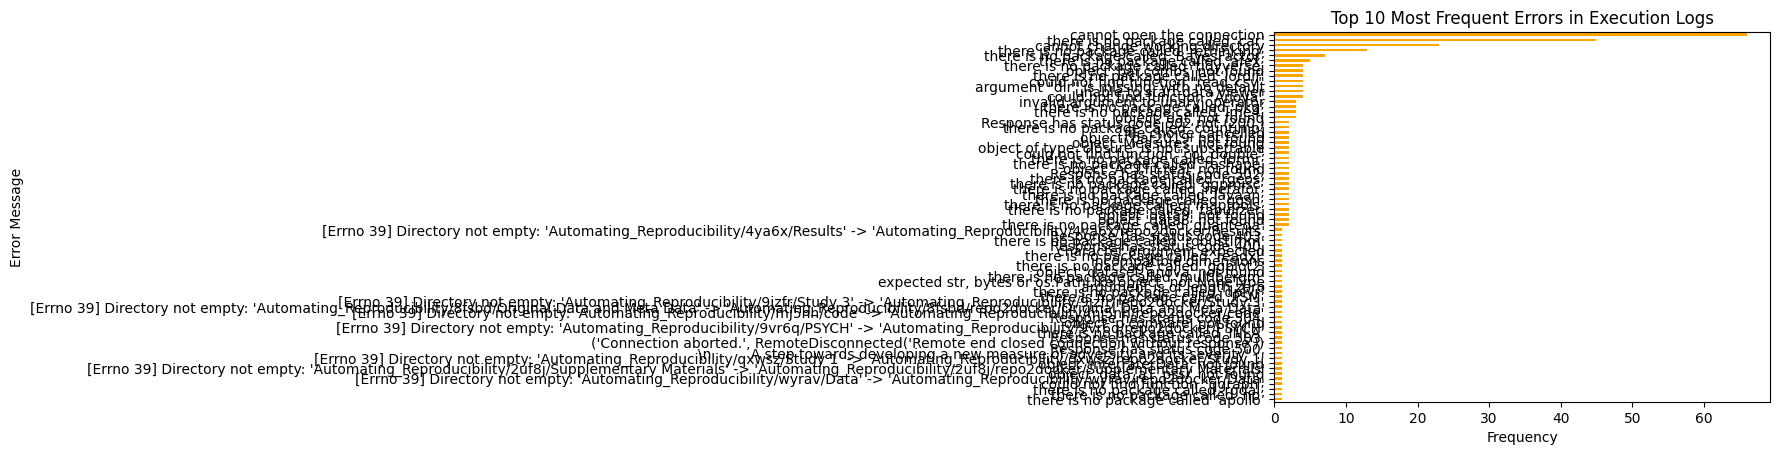

In [77]:


# Plot error frequency
plt.figure(figsize=(12, 6))
error_df.plot(kind="barh", x="Error Message", y="Count", color="orange", legend=False)
plt.xlabel("Frequency")
plt.ylabel("Error Message")
plt.title("Top 10 Most Frequent Errors in Execution Logs")
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()

In [78]:

txt_file_path = os.path.join(BASE_DIR, "project_ids.txt")  # Project IDs from text file

with open(txt_file_path, "r") as file:
    txt_project_ids = {line.strip() for line in file if line.strip()}  # Use a set for quick lookup

print(f"Found {len(txt_project_ids)} project IDs in '{txt_file_path}'")

df = pd.read_csv(csv_file_path)

if "Project ID" not in df.columns:
    raise ValueError("'Project ID' column is missing in the CSV!")

csv_project_ids = set(df["Project ID"].astype(str).unique())  # Convert all to string for consistency

print(f"Found {len(csv_project_ids)} unique project IDs in '{csv_file_path}'")


Found 296 project IDs in '/Users/fury/project_ids.txt'
Found 253 unique project IDs in '/Users/fury/execution_results.csv'


In [79]:

missing_projects = txt_project_ids - csv_project_ids  # IDs in TXT but not in CSV
# Display Results
if missing_projects:
    print(f"⚠️ {len(missing_projects)} projects are missing from the CSV:")
    print("\n".join(missing_projects))
else:
    print("✅ All project IDs from the text file exist in the CSV!")

⚠️ 43 projects are missing from the CSV:
qsa5w
dkrhy
82dqk
9vr6q
9gq4a
b7krz
9jzfr
m72gb
kpe75
egpr5
dhmjx
jpxts
4ya6x
8fsbd
xuz8d
wyrav
u3wby
6krj7
mj5nh
9vn68
gwn4y
akywf
p46mb
pnug5
srbcf
ha4q8
3aryn
y5gr9
a6tuw
fdp39
vy763
yhmbd
qjfv4
a8htx
3uyjt
ajf3h
amd3r
hu2n8
zh3f4
hfy4k
dh32q
b5ydr
975k3


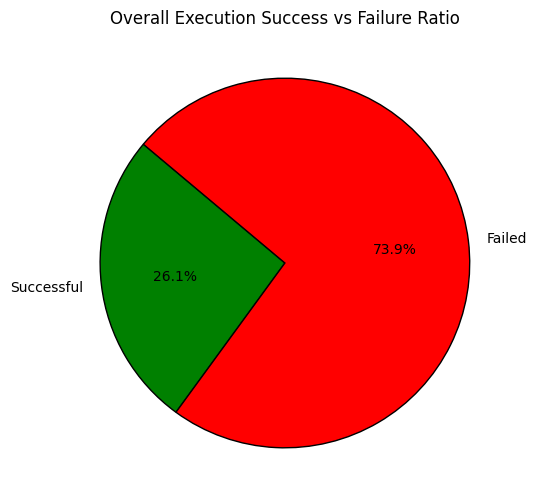

In [16]:
# Reload the execution results CSV file

execution_results = pd.read_csv(cleaned_csv_path)

# Count the total number of successful and failed executions
success_fail_count = execution_results.groupby(["Project ID", "Execution Status"]).size().unstack(fill_value=0)

# Compute total successful and failed executions across all projects
total_successful = success_fail_count.get("Successful", 0).sum()
total_failed = success_fail_count.get("Failed", 0).sum()


# Alternative Visualization 2: Pie Chart for Overall Success vs Failure
fig, ax = plt.subplots(figsize=(6, 6))
plt.pie([total_successful, total_failed], labels=["Successful", "Failed"], autopct='%1.1f%%', colors=["green", "red"], startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Overall Execution Success vs Failure Ratio")
plt.show()


# Display total counts
total_counts_df = pd.DataFrame({"Execution Status": ["Successful", "Failed"], "Total Count": [total_successful, total_failed]})



In [18]:
#total_errors = error_df["Successful"].sum()
print(f"🔍 Total number of errors: {total_counts_df}")

🔍 Total number of errors:   Execution Status  Total Count
0       Successful          121
1           Failed          343


In [81]:
# Re-import necessary libraries since execution state was reset
import pandas as pd

# Define relative paths
project_id_file_path = "project_id_r_code_file.csv"
execution_results_file_path = "execution_results_cleaned.csv"
updated_project_file_path = "updated_project_id_r_code_file.csv"

# Load the project ID and execution results data
df_project = pd.read_csv(project_id_file_path)
df_execution = pd.read_csv(execution_results_file_path)

# Merge execution results into the project file based on Project ID and R Code File
df_merged = df_project.merge(
    df_execution,
    left_on=["Project ID", "R Code File"],
    right_on=["Project ID", "R/Rmd Script"],
    how="left"
)

# Drop redundant column
df_merged = df_merged.drop(columns=["R/Rmd Script"])

# Save the updated file
df_merged.to_csv(updated_project_file_path, index=False)


In [82]:
import pandas as pd
import os

# Define relative file paths (assuming CSVs are in the 'data' folder in the notebook directory)
statcodesearch_file_path = "statcodesearch_pckg_urls (1).csv"
updated_project_file_path = "updated_project_id_r_code_file.csv"
output_file_path = "updated_statcodesearch.csv"

# Load both CSV files
df_statcodesearch = pd.read_csv(statcodesearch_file_path)
df_updated_project = pd.read_csv(updated_project_file_path)

# Extract Project ID from the Source column (last part of the URL)
df_statcodesearch["Project ID"] = df_statcodesearch["Source"].str.extract(r'\/([a-zA-Z0-9]+)\/?$')

# Normalize the Idx column by removing extra numbers before and after the file name
df_statcodesearch["Normalized R Code File"] = df_statcodesearch["Idx"].str.replace(r'^\d+\s+|\s+\d+$', '', regex=True)

# Merge execution status from updated_project file based on Project ID and R Code File
df_statcodesearch = df_statcodesearch.merge(
    df_updated_project[["Project ID", "R Code File", "Execution Status"]],
    left_on=["Project ID", "Normalized R Code File"],
    right_on=["Project ID", "R Code File"],
    how="left"
)

# Drop redundant "R Code File" column
df_statcodesearch.drop(columns=["R Code File"], inplace=True)

# Save the updated file
df_statcodesearch.to_csv(output_file_path, index=False)

# Display the updated DataFrame
df_statcodesearch.head()


,Idx,Comment,Code,License,Label,Author,Datasets,Packages,Packages URL,Output Types,...,Source,Title,Project description,Domain,Publication date,Date modified,DOI,Project ID,Normalized R Code File,Execution Status
0,10222 pupillometry_tutorial_calignano.R 0,exclude NAs from data,"data <- data[complete.cases(data$average), ] s...",CC0 1.0 Universal,Data Variable,Giulia Calignano,['dataset_tutorial.csv'],"['dplyr', 'naniar', 'plyr', 'plyr', 'mgcv', 'i...","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,https://osf.io/qhaf8/,BCCCD23 - Elements of Cognitive Pupillometry,Here you will find all the materials of the tu...,Psychology,2022-10-24,2023-05-25,10.17605/OSF.IO/QHAF8,qhaf8,pupillometry_tutorial_calignano.R,Failed
1,9088 Social Factors COVID-19_Konrad.R 18,"2. compare model indices (ICC, conditional an...","tab_model(model0.1, model1, model1_full) tab_m...",CC-By Attribution 4.0 International,Statistical Modeling,Annika Konrad,['data_Konrad_etal.csv'],"['compareGroups', 'psych', 'lme4', 'emmeans', ...","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,https://osf.io/8edp7/,"Social factors, pre-existing mental disorders ...",We aimed to predict psychological distress ove...,Social Science,2021-05-04,2022-07-13,NaN,8edp7,Social Factors COVID-19_Konrad.R,Failed
2,9088 Social Factors COVID-19_Konrad.R 21,Plot robust model 1 get predicted Values for ...,"gg_model1 <- ggpredict(model1_robust, c(""dayco...",CC-By Attribution 4.0 International,Visualization,Annika Konrad,['data_Konrad_etal.csv'],"['compareGroups', 'psych', 'lme4', 'emmeans', ...","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,https://osf.io/8edp7/,"Social factors, pre-existing mental disorders ...",We aimed to predict psychological distress ove...,Social Science,2021-05-04,2022-07-13,NaN,8edp7,Social Factors COVID-19_Konrad.R,Failed
3,10940 AnalysisPost-PAP.R 11,count of articles that generated data using ex...,"GenerateData[2,2] <- sum(MMCPSR_emp$EHPdata) G...",Other,Data Variable,Daniel Solomon,NaN,"['viridis', 'forcats', 'ggstance']","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,https://osf.io/uhma8/,Mapping Methods in Contemporary Political Scie...,This project surveys the conduct of political ...,Psychology,2021-09-23,2023-05-12,NaN,uhma8,AnalysisPost-PAP.R,NaN
4,5080 SRMA2019_analyses.R 0,Data organization Rename columns/variable na...,colnames(srmadata) srmadata <- srmadata %>% re...,CC-By Attribution 4.0 International,Data Variable,Daniel Umpierre,['SRMAdata.csv'],"['tidyverse', 'DescTools', 'ggplot2']","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,https://osf.io/ntw7d/,Strengthening the Evidence in Exercise Science...,The SEES-Initiative generates prospective and ...,Social Science,2019-03-06,2022-12-02,10.17605/OSF.IO/NTW7D,ntw7d,SRMA2019_analyses.R,Failed
